In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import backtrader as bt
from typing import Tuple, List
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Load & align data

In [3]:
price_path   = r'C:\Users\Leo Hubmann\Desktop\thesis\data\price_data\bitcoin_2021_2024.csv'
vader_path   = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_vader_sentiment_v2.csv'
finbert_path = r'C:\Users\Leo Hubmann\Desktop\BachelorThesis_data\all_daily_finbert_sentiment_v4.csv'

In [4]:
price = (pd.read_csv(price_path,   parse_dates=['date'], low_memory=False)
         .set_index('date')
         .loc['2020-12-31':'2024-12-31', 'close'])

vader = (pd.read_csv(vader_path,   parse_dates=['date'], low_memory=False)
        .set_index('date')['daily_vader_sentiment'])

finbert = (pd.read_csv(finbert_path, parse_dates=['date'], low_memory=False)
        .set_index('date')['daily_finbert_score'])

In [5]:
df = pd.concat({'close': price, 'vader': vader, 'finbert': finbert}, axis=1)

In [6]:
# compute log returns
df['ret'] = np.log(df['close']).diff()
df = df.dropna()

In [7]:
ROLL_Z   = 90      # z-score window
# rolling standardisation
df['vader_z']   = (df['vader']   - df['vader'].rolling(ROLL_Z).mean())   / df['vader'].rolling(ROLL_Z).std()
df['finbert_z'] = (df['finbert'] - df['finbert'].rolling(ROLL_Z).mean()) / df['finbert'].rolling(ROLL_Z).std()

df['sent_raw'] = df[['vader_z', 'finbert_z']].mean(axis=1)

# composite + cap ±3 σ
# df['sent_raw']  = df[['vader_z', 'finbert_z']].mean(axis=1).clip(-3, 3)

In [8]:
SHARPE_DAYS = 365          # 365 for crypto

# annual sharpe, but with rf = 0
def ann_sharpe(ret: pd.Series) -> float:
    return np.sqrt(SHARPE_DAYS) * ret.mean() / ret.std()

def cum_curve(ret: pd.Series) -> pd.Series:
    """Cumulative growth of 1 unit."""
    return np.exp(ret.cumsum())

def max_drawdown(ret: pd.Series) -> float:
    r   = ret.fillna(0)            # ← ①  replace first NaN by 0-return
    eq  = np.exp(r.cumsum())       # cumulative equity
    roll_max = np.maximum.accumulate(eq)
    dd  = 1 - eq / roll_max
    return dd.max()

In [9]:
# strat1_composite.ipynb

ROLL_PCT   = 60
TH_UP, TH_DN = 0.75, 0.25
TC = 0.001        # 0.10 % round-trip fee
EMA_GRID = range(3, 11)
TRAIN_END = '2023-12-31'

def build_strategy(df_in: pd.DataFrame, ema_span: int, return_alloc=False):
    
    d = df_in.copy()

    # 1) Smooth sentiment
    d['sent_ema'] = d['sent_raw'].ewm(span=ema_span, adjust=False).mean()

    # 2) Adaptive thresholds -> rolling percentiles
    p75 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_UP)
    p25 = d['sent_ema'].rolling(ROLL_PCT).quantile(TH_DN)

    # 3) regime → base allocation
    d['regime'] = np.where(d['sent_ema'] > p75, 'bull',
                           np.where(d['sent_ema'] < p25, 'bear', 'neutral'))
    alloc_map = {'bull': 1.0, 'neutral': 0.10, 'bear': 0.0}
    d['alloc_daily'] = d['regime'].map(alloc_map)

    # 4) weekly rebalance (Monday close)
    d['alloc'] = (d['alloc_daily']
                   .resample('W-MON')
                   .first()
                   .reindex(d.index, method='ffill'))

    # 5) Strategy returns with TC
    alloc_prev = d['alloc'].shift()
    tc = np.abs(d['alloc'] - alloc_prev) * TC
    strat_ret = alloc_prev * d['ret'] - tc.fillna(0)

    if return_alloc:
        return strat_ret, d['alloc']
    return strat_ret

In [10]:
# hyper param optimization (refer to BI lecture?) GRID-SEARCH  (find EMA span on 2021-23 data to avoid look-ahead)
is_mask = df.index <= TRAIN_END
grid_results: List[Tuple[int, float]] = []

for span in EMA_GRID:
    r   = build_strategy(df, span)
    sh  = ann_sharpe(r[is_mask])
    grid_results.append((span, sh))

best_span, best_sh    = max(grid_results, key=lambda x: x[1])
print(f'Best EMA span (IS 2021-23) = {best_span}   |  Sharpe = {best_sh:.2f}')

Best EMA span (IS 2021-23) = 5   |  Sharpe = 0.22


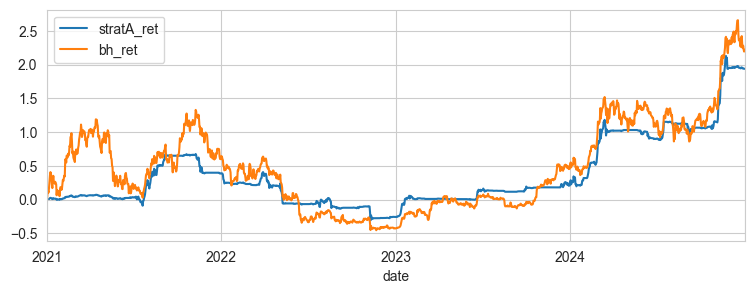

In [11]:
df['stratA_ret'] = build_strategy(df, best_span)
df['bh_ret']    = df['ret']                     # buy-and-hold benchmark

oos_mask        = df.index > TRAIN_END

# cum performance (lol)
(np.exp(df[['stratA_ret','bh_ret']].cumsum()) - 1).plot(figsize=(9,3));

In [12]:
# single code block, directly with frozen ema
df['stratA_ret'], df['alloc'] = build_strategy(df, best_span, return_alloc=True)
df['bh_ret'] = df['ret']

# performance table
def stats(label, r):
    return pd.Series({
        'Total Ret': cum_curve(r).iloc[-1],
        'Ann Vol': r.std()*np.sqrt(SHARPE_DAYS),
        'Sharpe': ann_sharpe(r),
        'Max DD': max_drawdown(r)
    }, name=label)

is_mask  = df.index <= TRAIN_END
oos_mask = df.index >  TRAIN_END

table = pd.concat({
    'Full':  pd.concat([stats('Strategy', df['stratA_ret']),
                        stats('Buy&Hold', df['bh_ret'])], axis=1),
    'IS':    pd.concat([stats('Strategy', df.loc[is_mask, 'stratA_ret']),
                        stats('Buy&Hold', df.loc[is_mask, 'bh_ret'])], axis=1),
    'OOS':   pd.concat([stats('Strategy', df.loc[oos_mask, 'stratA_ret']),
                        stats('Buy&Hold', df.loc[oos_mask, 'bh_ret'])], axis=1)
}, axis=1).round(2)

display(table)

Full                IS               OOS         
          Strategy Buy&Hold Strategy Buy&Hold Strategy Buy&Hold
Total Ret     2.94     3.22     1.21     1.46     2.43     2.21
Ann Vol       0.30     0.62     0.28     0.65     0.33     0.53
Sharpe        0.91     0.47     0.22     0.19     2.70     1.49
Max DD        0.59     0.77     0.59     0.77     0.14     0.26

In [13]:
VOL_WIN = 30
df['vol30'] = df['ret'].rolling(VOL_WIN).std() * np.sqrt(365)
# VOL_TARGET = df.loc[:TRAIN_END, 'vol30'].median()
VOL_TARGET = df.loc[:TRAIN_END, 'vol30'].median() * 0.8	
print(f"Target vol = {VOL_TARGET:.2%}")

def build_strategy_vol(df_in: pd.DataFrame, ema_span: int, return_alloc=False):
    ret_base, alloc_base = build_strategy(df_in, ema_span, return_alloc=True)

    # inverse-vol scaling factor (capped at 1)
    scale = (VOL_TARGET / df_in['vol30']).clip(upper=1.0)
    alloc_rw = alloc_base * scale

    alloc_prev = alloc_rw.shift()
    fee = np.abs(alloc_rw - alloc_prev) * TC
    strat_ret = alloc_prev * df_in['ret'] - fee.fillna(0)

    return (strat_ret, alloc_rw) if return_alloc else strat_ret

df['stratB_ret'], df['allocB'] = build_strategy_vol(df, best_span, return_alloc=True)


Target vol = 46.66%



=== Sharpe ratios (365-day) ===
Strategy A  IS : 0.22 | OOS : 2.7
Strategy B  IS : 0.1 | OOS : 2.83

Max-DD OOS | A: 0.14 | B: 0.12


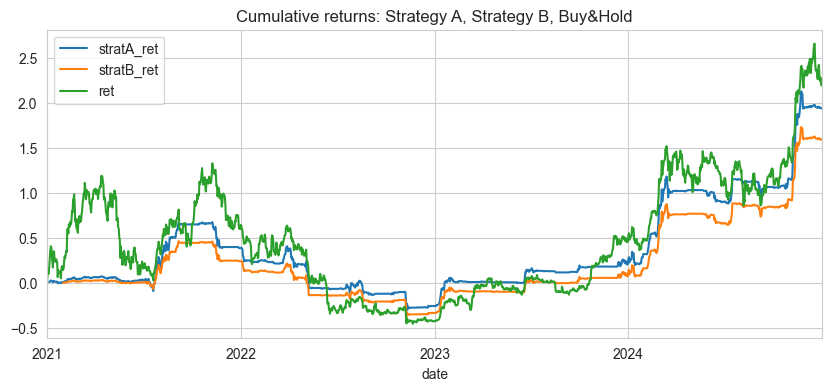

In [14]:
oos_mask = df.index > TRAIN_END
print("\n=== Sharpe ratios (365-day) ===")
print("Strategy A  IS :", ann_sharpe(df.loc[~oos_mask,'stratA_ret']).round(2),
      "| OOS :", ann_sharpe(df.loc[ oos_mask,'stratA_ret']).round(2))
print("Strategy B  IS :", ann_sharpe(df.loc[~oos_mask,'stratB_ret']).round(2),
      "| OOS :", ann_sharpe(df.loc[ oos_mask,'stratB_ret']).round(2))

print("\nMax-DD OOS | A:", max_drawdown(df.loc[oos_mask,'stratA_ret']).round(2),
      "| B:", max_drawdown(df.loc[oos_mask,'stratB_ret']).round(2))

# quick equity curves (full sample)
cum_curve(df[['stratA_ret','stratB_ret','ret']]).sub(1).plot(figsize=(10,4));
plt.title('Cumulative returns: Strategy A, Strategy B, Buy&Hold');
plt.show()

In [15]:
is_mask  = df.index <= TRAIN_END
oos_mask = df.index >  TRAIN_END

table = pd.concat({
    'Full':  pd.concat([stats('Strategy', df['stratA_ret']),
                        stats('Buy&Hold', df['bh_ret']),
                        stats('Strategy B', df['stratB_ret'])
                        ], axis=1),
    
    'IS':    pd.concat([stats('Strategy', df.loc[is_mask, 'stratA_ret']),
                        stats('Buy&Hold', df.loc[is_mask, 'bh_ret']),
                        stats('Strategy B', df.loc[is_mask, 'stratB_ret'])
                        ], axis=1),
    
    'OOS':   pd.concat([stats('Strategy', df.loc[oos_mask, 'stratA_ret']),
                        stats('Buy&Hold', df.loc[oos_mask, 'bh_ret']),
                        stats('Strategy B', df.loc[oos_mask, 'stratB_ret'])
                        ], axis=1)
    
}, axis=1).round(2)

display(table)

Full                           IS                          OOS  \
          Strategy Buy&Hold Strategy B Strategy Buy&Hold Strategy B Strategy   
Total Ret     2.94     3.22       2.59     1.21     1.46       1.08     2.43   
Ann Vol       0.30     0.62       0.26     0.28     0.65       0.25     0.33   
Sharpe        0.91     0.47       0.92     0.22     0.19       0.10     2.70   
Max DD        0.59     0.77       0.57     0.59     0.77       0.57     0.14   

                               
          Buy&Hold Strategy B  
Total Ret     2.21       2.41  
Ann Vol       0.53       0.31  
Sharpe        1.49       2.83  
Max DD        0.26       0.12

In [16]:
rho_A_full  = df[['stratA_ret','ret']].dropna().corr().iloc[0,1]
rho_B_full  = df[['stratB_ret','ret']].dropna().corr().iloc[0,1]

print(f"Daily-return correlation vs. BTC")
print(f"  Strategy A (neutral 10%) : {rho_A_full:.2f}")
print(f"  Strategy B (vol aware)   : {rho_B_full:.2f}")

Daily-return correlation vs. BTC
  Strategy A (neutral 10%) : 0.58
  Strategy B (vol aware)   : 0.56


In [21]:
# save returns as csv
df[['stratB_ret', 'allocB']].to_csv(r'C:\Users\Leo Hubmann\Desktop\thesis\data\strat3_volacomp_alloc.csv')